# Symmetry-breaking_motility_in_active_fluids
### Kiwon Kim, Yunsik Choe, Yongjoo baek
### numerical model validation

# Motivation
✦ In ﬂuids at equilibrium, a moving object typically experiences a drag force that opposes its velocity.

✦ In contrast, using a model of a soft object immersed in an ideal active ﬂuid, we ﬁnd that the drag force can apply in the direction of the object’s velocity. 

✦ This implies that active particles can impart their motility even to symmetric bodies through a spontaneous symmetry-breaking mechanism. 

✦ Questions 

❖ Can we describe this phenomenon as a phase transition? 

❖ What does this phenomenon imply about the cargo transport in active ﬂuids?

In [1]:
import numpy as np
import pandas as pd
from tqdm import trange   # for progess bar
import matplotlib.pyplot as plt
%matplotlib inline

from RTP_simul import RTP_lab

## Model 1: a single run-and-tumble particle

# $$ \dot{x} = us(t) $$

### where $\dot{x}$ is the velocity of the particle, u is the speed of the particle(constant), s(t) is the direction $\pm$ 1
### the direction is rearranged at a tumble rate $\alpha$


### check the validity of model by showing that diffusion ~ $(2u^2/\alpha)t$ for large t

  2%|▏         | 179/10000 [00:00<00:05, 1785.88it/s]

RTP model initialized


100%|██████████| 10000/10000 [00:05<00:00, 1955.30it/s]


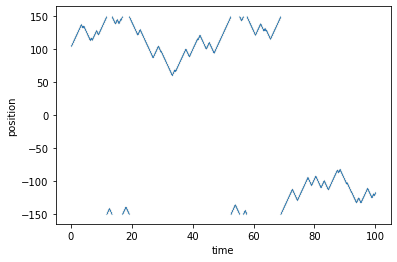

In [2]:
R1 = RTP_lab(alpha=1, u=10, len_time=100, N_time=100, N_ptcl=20000)

# for model 1, no passive object movement
R1.F=0
R1.muw=0
# single active particle trajectory
    
R1.N_ptcl = 1
R1.set_zero()
history = np.empty(R1.N_simul)
        
        
for i in trange(R1.N_simul):
    R1.time_evolve()
    history[i] = R1.x
        
plt.scatter(R1.time,history, s=0.001)
plt.xlabel('time')
plt.ylabel('position')
plt.show()

  0%|          | 30/10000 [00:00<00:33, 297.06it/s]

RTP model initialized


100%|██████████| 10000/10000 [00:45<00:00, 220.20it/s]


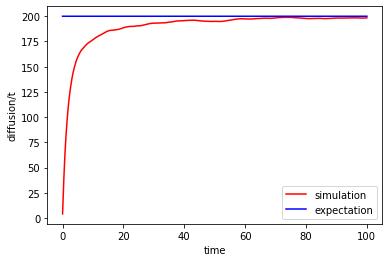

In [3]:
R1 = RTP_lab(alpha=1, u=10, len_time=100, N_time=100, N_ptcl=20000)

# for model 1, no passive object movement
R1.F=0
R1.L=100000   # much larger than activity to check diffusion  in non-periodic condition
R1.muw=0


# check diffusion

history_diffusion = np.empty(0)
R1.set_zero()
R1.x *=0    # all particles in starting point

D_eff = R1.u**2/R1.alpha
        
for __ in trange(R1.N_simul):
    R1.time_evolve()
    history_diffusion = np.append(history_diffusion,np.average(R1.x**2))
        
plt.plot(R1.time[1:], history_diffusion[1:]/R1.time[1:],   c = 'red',label = 'simulation')  # to ignore divide by zero
plt.plot(R1.time, 2*D_eff*np.ones(R1.N_simul), c = 'blue',label = 'expectation')
plt.xlabel('time')
plt.ylabel('diffusion/t')
plt.legend()
plt.show()

## Model 2 : a wall moving at a constant velocity

### add periodic boundary condition

### equation of motion becomes 
## $\dot{x}=-\mu\partial_x V(x-vt)+us(t)$

### or changing to the frame of reference fixed to the wall ($x_{wall} = x_{lab} -vt$)
## $\dot{x} = -\mu\partial_xV(x)-v+us(t)$

## calculate the steady-state average force exerted by the active particle on the wall as a function of the wall velocity v

# $$\bar{F}_w(v) = \langle\int_{-l/2}^{l/2}{dxV'(x)}\rangle_v $$
## the calculation is done by summing the value of V'(x) for many particles, averaged for long time

## comparing with theory

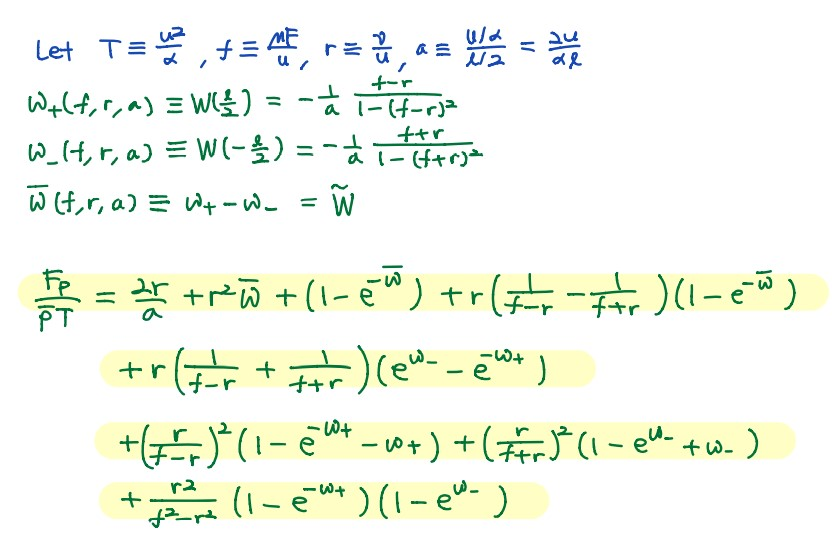

## Force applied to wall as function of v
## averaged over time

In [8]:
def theo_F(R,a,r):    # alpha, l fixed, use v/u=r
    u = a*R.alpha*R.l/2
        
    T = u**2/R.alpha
    f = R.mu*R.F/u
        
    wp = -(1/a)*(f-r)/(1-(f-r)**2)
    wn = -(1/a)*(f+r)/(1-(f+r)**2)
    wb = wp-wn
        
    F_avg = T*(2*r/a + r**2*wb + (1-np.exp(-wb))  + r*(1/(f-r) -1/(f+r))*(1-np.exp(-wb))
                   +r*(1/(f-r) + 1/(f+r))*(np.exp(wn)-np.exp(-wp))
                   +(r/(f-r))**2 * (1-np.exp(-wp)-wp)  + (r/(f+r))**2*(1-np.exp(wn)+wn)
                   + (r**2/(f**2-r**2))*(1- np.exp(-wp))*(1-np.exp(wn))
                  )
    return F_avg





n_batch = 200
n_particle=1000
a=1
muFu = 1
repeat=500


R2 = RTP_lab(alpha=1, u=10, len_time=100, N_time=100,N_X=n_batch, N_ptcl=n_particle, mu=1, model=2)

R2.u = a*R2.l/2
R2.F = muFu*R2.u/R2.mu

R2.set_zero()

R2.v = np.linspace(0,R2.u*(0.999-muFu),n_batch)   # each value gives the velocity to be applied for each batches
            
    
for __ in trange(int(R2.N_simul)):   # to stable distribution
    R2.time_evolve()
        
    F_v = np.zeros(n_batch)
            
    error_measure = np.empty(repeat)
        
# computation part with time evolving
for rep in trange(repeat):
                
    for __ in range(R2.N_simul):   # long enough time
        F_v += np.sum(R2.partial_V(self.x),axis=0)              # summing the V' at each x
        self.time_evolve()
                                      # averaging over time
        F_simul = (R2.L/R2.N_ptcl[0]) *F_v/((rep+1)*R2.N_simul)
        F_theo = theo_F(R2,a,R2.v/R2.u)
        F_error = F_simul-F_theo
                    
        error_measure[rep] = np.sqrt(np.average(F_error**2))
            
            
        if rep%20==0:
                    
            print('r=',rep+1)
            plt.scatter( self.v/self.u, F_simul, s=2,label='simul')
                
                
            vu_axis = np.linspace(0,0.999-muFu,10000)
            F_avg_axis = self.theo_F(a,vu_axis)
            plt.plot(vu_axis,F_avg_axis, label='theory', c='r')
                
            plt.ylabel('F')
            plt.xlabel('v/u')
            #plt.title(self.title)
            plt.grid(True)
            plt.legend()
            plt.show()
                
            plt.plot(error_measure[:rep+1])
            plt.xscale('log')
            plt.yscale('log')
            plt.show()
                



  0%|          | 5/10000 [00:00<04:14, 39.30it/s]

RTP model initialized


 52%|█████▏    | 5208/10000 [02:10<01:59, 39.97it/s]


KeyboardInterrupt: 

## Model 3. wall pushed by active particles

## VX distribution varying $\mu$F/u

In [ ]:
# phase transition